# PyTorch Workflow

In [ ]:
import torch
from torch import nn # torch.nn contains all the building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

## Data Preparing and Loading



Data can be anything in ML

* Excel Spreadsheet
* Images
* Audio
* Text

Machine Learning consists of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

Let's start by using a linear regression formula to make a straight line with known parameters

In [ ]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # Note: We use capital letters for matrices or tensors and small letters for vectors
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets



In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X)) # This means that 80% of the data is the training set
train_split

40

In [ ]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14})

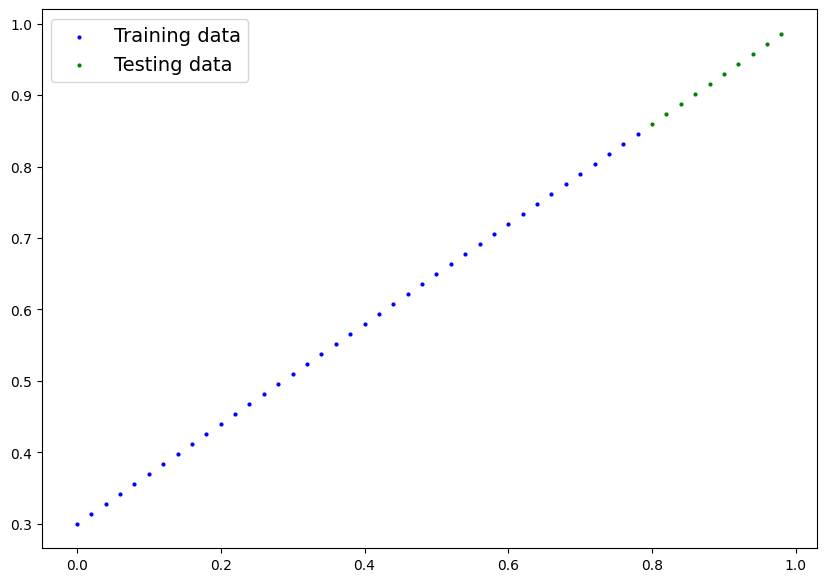

In [ ]:
plot_predictions()

## Building a Linear Regression Model

What our model does:
* Start with random values (weight and bias)
* Look at training data and adjust random values to get as close to ideal value as possible

How it does it:
1. Gradient Descent
2. Backpropagation

In [ ]:
import torch
from torch import nn
# Create a class for the model
class LinearRegressionModel(nn.Module): # almost all classes in PyTorch import from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    # Forward method for computaion
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

* `torch.nn` - contains all the building blocks for computational graphs
* `torch.nn.Parameters` - what parameters our model should try and learn
* `torch.nn.Module` - base class for PyTorch models, if you inherit it, always overwrite forward()
* `torch.optim` - contains all the optimization algorithms
* `def forward()` - All nn.Module subclasses need to implement a forward() method

[Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html)

### Checking the model's contents

We can do that by using the `parameters()` method
This method returns a generator and thus needs to be converted into a list to be made viewable

In [ ]:
# Create a random seed
SEED = 42
torch.manual_seed(SEED)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check the model parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions

We will use `X_test` to see how our model predicts `y_test`

When we pass data through our model, it's going to run it through the `forward()` method

In [ ]:
# Make predictions with the model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

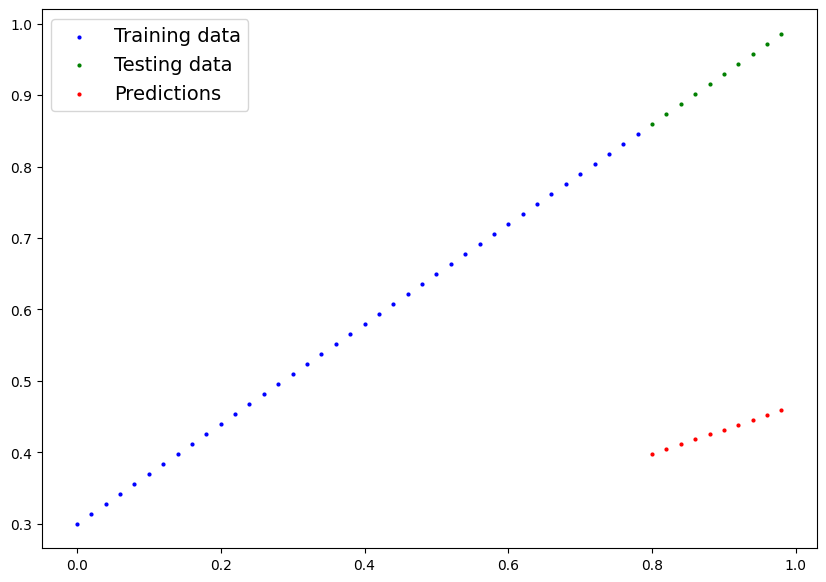

In [ ]:
plot_predictions(predictions = y_preds)

## Train model

Training is entirely about the model learning some *known* parameters from some *unknown* or *random* parameters

One such way of measuring how poor the model performance is, is a loss function

* Note: Loss function is also called cost function or criterion

Things needed to train a model:
* **Loss function:** A function to measure how wrong your model is, the lesser the better
* **Optimizer:** Adjusts the models parameters based on the model's parameters to improve the loss function
  * The optimizer consists of the following:
    * params - the model parameters you want to optimize
    * lr - the learning rate
* **Training Loop**
* **Testing Loop**

In [ ]:
# Setup the loss function
loss_fn = nn.L1Loss() # L1 loss is also called MAE (Mean Absolute Error) Loss

# Setup the optimizer (stochastic gradient descent)
optimizer =  torch.optim.SGD(params = model_0.parameters(), lr = 0.01)

### Building a training loop

Things needed in a training loop:
1. Loop through the data
2. Forward pass to make predictions
3. Calculate the loss to compare predictions to ground truth
4. Optimizer zero grad
5. Backpropagation to calculate gradient of parameters w.r.t the loss
6. Optimizer step to adjust model's parameters and improve the loss (**gradient descent**)

In [ ]:
# Epoch - One entire loop through the data
epochs = 200
# Tracking values
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # sets all parameters to turn on gradient tracking

  # 2. Forward pass
  y_pred = model_0(X_train)

  # 3. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 4. Zero the gradient on the optimizer (they accumulate by default)
  optimizer.zero_grad()

  # 5. Backpropagation
  loss.backward()

  # 6. Optimizer step
  optimizer.step()

  # Testing
  model_0.eval() # Turns off different settings in the model not needed for testing

  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # Print the model parameters
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

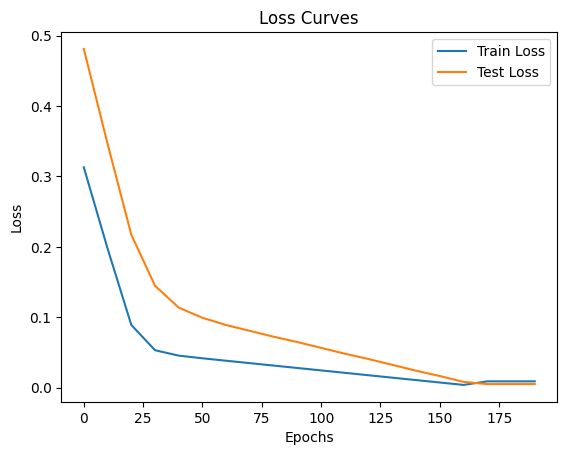

In [ ]:
import numpy as np
# Plotting the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = 'Train Loss')
plt.plot(epoch_count, test_loss_values, label = 'Test Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

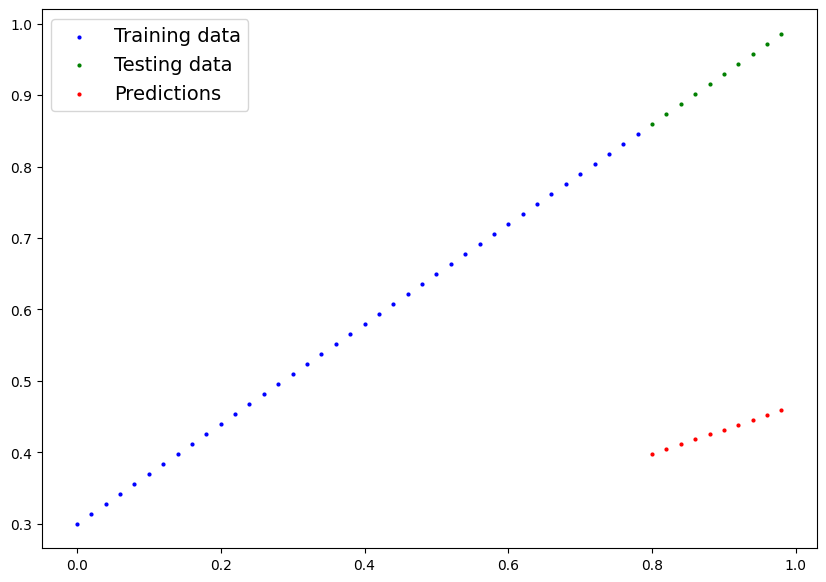

In [ ]:
plot_predictions(predictions = y_preds)

In [ ]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)

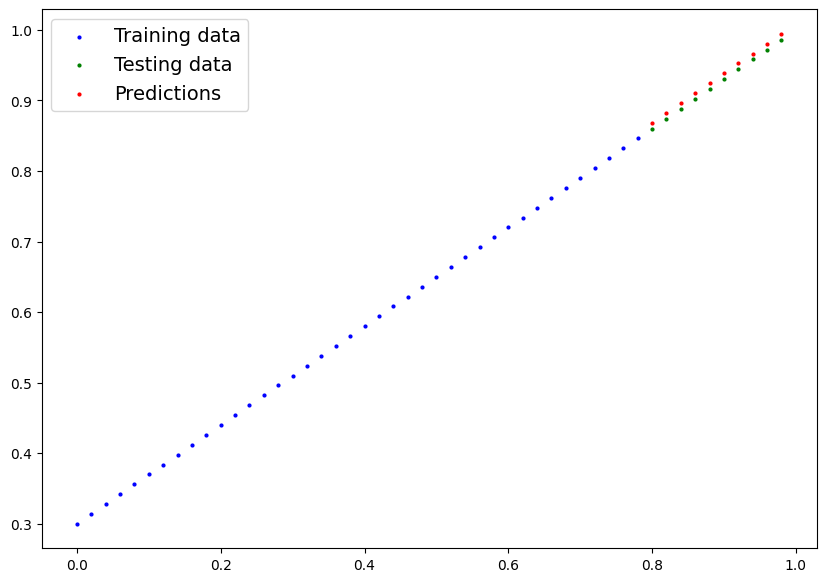

In [ ]:
plot_predictions(predictions = y_pred_new)

## Saving and Loading a model in PyTorch

There are three main methods to save and load models:

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# Create model's directory
MODEL_PATH = Path('/content/drive/MyDrive/ML Models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model's save path
MODEL_NAME = 'pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state_dict()
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)


Saving model to: /content/drive/MyDrive/ML Models/pytorch_workflow_model_0.pth


In [ ]:
# Loading the model
from pathlib import Path

# Create model's directory
MODEL_PATH = Path('/content/drive/MyDrive/ML Models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model's save path
MODEL_NAME = 'pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<ipython-input-15-480218e26a11>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## Putting it all together

In [1]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for faster computing)

If no GPU is available, this code will default to using CPU

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


### Data

In [3]:
# Create some data using linear regression y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Split data
train_split = int(0.75 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(37, 37, 13, 13)

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14})

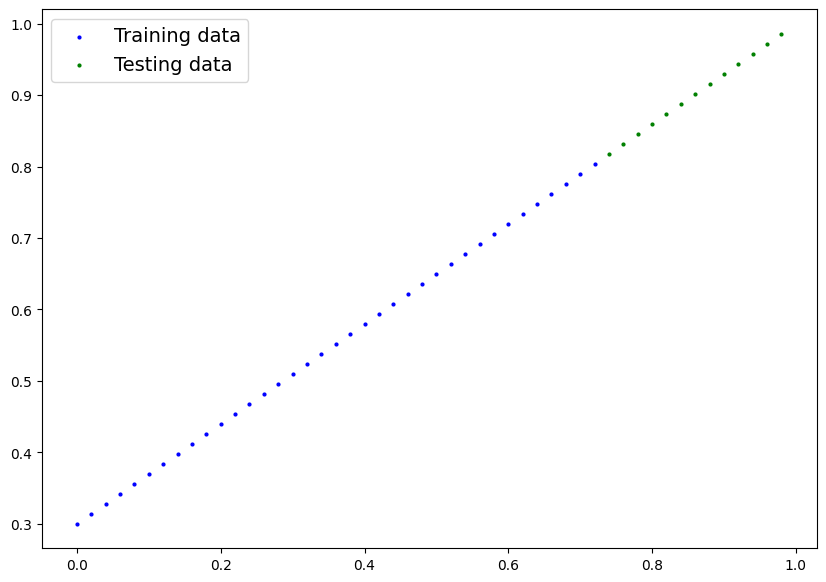

In [6]:
# Plot the data
plot_predictions()

## Building a PyTorch Linear Model

In [8]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear = nn.Linear(in_features = 1, out_features = 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear.weight', tensor([[0.7645]])),
              ('linear.bias', tensor([0.8300]))]))

In [9]:
# Set the model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [14]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.001)

In [15]:
# Training loop
torch.manual_seed(42)

epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []

# Putting data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero the gradient
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_pred = model_1(X_test)
    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.005238604731857777 | Test Loss: 0.008589084260165691
Epoch: 10 | Loss: 0.0012158413883298635 | Test Loss: 0.0030818902887403965
Epoch: 20 | Loss: 0.0009142104536294937 | Test Loss: 0.0022763472516089678
Epoch: 30 | Loss: 0.0006133970455266535 | Test Loss: 0.0014708088710904121
Epoch: 40 | Loss: 0.0003131547709926963 | Test Loss: 0.0007369564264081419
Epoch: 50 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 60 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 70 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 80 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 90 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 100 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 110 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 120 | Loss: 0.00048058180254884064 | Test Loss: 0.0011490079341456294
Epoch: 130 | Loss

In [16]:
model_1.state_dict()

OrderedDict([('linear.weight', tensor([[0.6994]], device='cuda:0')),
             ('linear.bias', tensor([0.3007], device='cuda:0'))])

### Making and evaluating predictions

In [17]:
# Turning model to evaluation mode
model_1.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8182],
        [0.8322],
        [0.8462],
        [0.8602],
        [0.8742],
        [0.8882],
        [0.9022],
        [0.9161],
        [0.9301],
        [0.9441],
        [0.9581],
        [0.9721],
        [0.9861]], device='cuda:0')

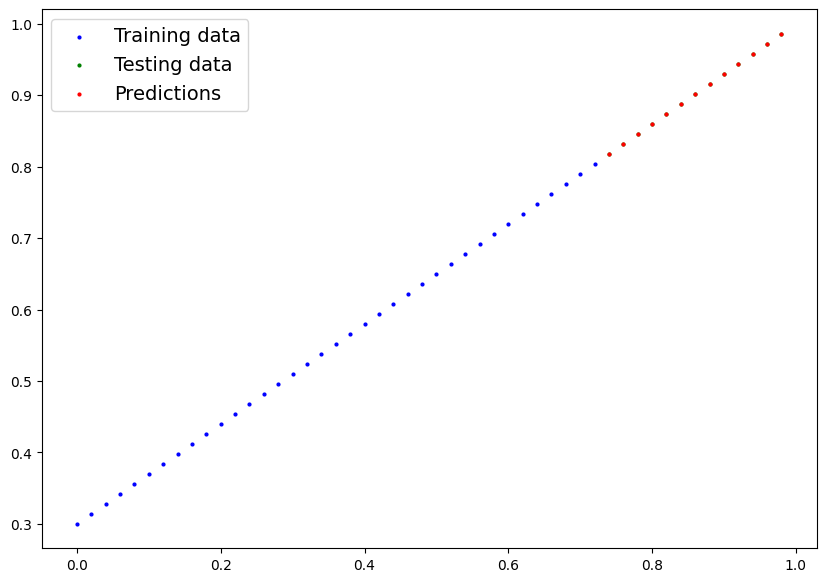

In [18]:
# Plot our predictions
plot_predictions(predictions = y_preds.cpu())

### Saving and Loading the model

In [20]:
from pathlib import Path
MODEL_PATH = Path('/content/drive/MyDrive/ML Models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [22]:
# Saving the model
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)
print(f'Model saved to: {MODEL_SAVE_PATH}')

Model saved to: /content/drive/MyDrive/ML Models/pytorch_workflow_model_1.pth


In [23]:
# Loading the model
loaded_model = LinearRegressionModelV2()
print(f'New model parameters: {loaded_model.state_dict()}')
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
print(f'Loaded model parameters: {loaded_model.state_dict()}')

New model parameters: OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])
Loaded model parameters: OrderedDict([('linear.weight', tensor([[0.6994]])), ('linear.bias', tensor([0.3007]))])


<ipython-input-23-ad1dcd0fab4f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
